In [7]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
    
from datetime import datetime
import pytz
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
from datetime import timedelta
    
import map_utils
    
from gen_lib import data_saver, generation_utils
from gen_lib.config import *
from gen_lib.locations import LocationData
from gen_lib.grid_generator import generate_location_heatmap, VariationConfig, GridGeneratorEnhanced
from gen_lib.trends import TrendConfig, TrendGenerator, save_trend_data
from gen_lib.time_series import TimeSeriesHeatmapGenerator, TimeSeriesConfig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
location_data = LocationData.from_files(
    shapefile_path="../gen_lib/data/500Cities_City_11082016/CityBoundaries.shp",
    locations=ALL_LOCATIONS
)

trend_generator = TrendGenerator(location_data)

In [25]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def generate_comparison_timeseries(timeseries_heatmaps: Dict[str, List[Dict]]) -> List[Dict]:
    """
    Generate a timeseries from heatmap data for comparison with original timeseries.
    
    Args:
        timeseries_heatmaps: Dictionary mapping timestamps to lists of heatmap points
        
    Returns:
        List of dicts with timestamp and aggregated value
    """
    comparison_series = []
    
    for timestamp, heatmap_points in sorted(timeseries_heatmaps.items()):
        if not heatmap_points:
            continue
            
        # Calculate weighted sum of intensities
        total_intensity = sum(point['intensity'] * point.get('count', 1) 
                            for point in heatmap_points)
        
        # Calculate average intensity
        avg_intensity = total_intensity / len(heatmap_points)
        
        comparison_series.append({
            'timestamp': timestamp,
            'value': avg_intensity
        })
    
    return comparison_series

def compare_timeseries(original_series: List[Dict], 
                      generated_series: List[Dict],
                      normalize: bool = True) -> Dict:
    """
    Compare original and generated timeseries and calculate metrics.
    
    Args:
        original_series: Original timeseries data
        generated_series: Generated timeseries from heatmaps
        normalize: Whether to normalize values to 0-1 range
        
    Returns:
        Dict with comparison metrics
    """
    # Convert to pandas DataFrames for easier manipulation
    orig_df = pd.DataFrame(original_series)
    gen_df = pd.DataFrame(generated_series)
    
    # Convert timestamps to datetime
    orig_df['timestamp'] = pd.to_datetime(orig_df['timestamp'])
    gen_df['timestamp'] = pd.to_datetime(gen_df['timestamp'])
    
    # Set timestamp as index
    orig_df.set_index('timestamp', inplace=True)
    gen_df.set_index('timestamp', inplace=True)
    
    # Align the series
    orig_aligned, gen_aligned = orig_df.align(gen_df, join='inner')
    
    if len(orig_aligned) == 0:
        raise ValueError("No matching timestamps between original and generated series")
    
    if normalize:
        # Normalize values
        orig_aligned['value'] = orig_aligned['value'] / orig_aligned['value'].max()
        gen_aligned['value'] = gen_aligned['value'] / gen_aligned['value'].max()
    
    # Calculate metrics
    differences = np.abs(orig_aligned['value'] - gen_aligned['value'])
    metrics = {
        'mean_absolute_error': differences.mean(),
        'max_difference': differences.max(),
        'min_difference': differences.min(),
        'correlation': orig_aligned['value'].corr(gen_aligned['value'])
    }
    
    # Convert back to list of dicts format
    original_normalized = [
        {'timestamp': str(idx), 'value': val} 
        for idx, val in orig_aligned['value'].items()
    ]
    
    generated_normalized = [
        {'timestamp': str(idx), 'value': val} 
        for idx, val in gen_aligned['value'].items()
    ]
    
    return {
        'metrics': metrics,
        'original': original_normalized,
        'generated': generated_normalized
    }

def plot_comparison(comparison_results: Dict):
    """
    Plot original vs generated timeseries for visual comparison.
    """
    # Convert to pandas for easier plotting
    original_df = pd.DataFrame(comparison_results['original'])
    original_df['timestamp'] = pd.to_datetime(original_df['timestamp'])
    
    generated_df = pd.DataFrame(comparison_results['generated'])
    generated_df['timestamp'] = pd.to_datetime(generated_df['timestamp'])
    
    plt.figure(figsize=(15, 6))
    plt.plot(original_df['timestamp'], original_df['value'], 
             label='Original', marker='o')
    plt.plot(generated_df['timestamp'], generated_df['value'], 
             label='Generated from Heatmaps', marker='x')
    
    plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    
    plt.title('Original vs Generated Timeseries Comparison')
    plt.xlabel('Time')
    plt.ylabel('Normalized Intensity')
    plt.legend()
    plt.grid(True)
    
    metrics = comparison_results['metrics']
    plt.figtext(0.02, 0.02, 
                f'MAE: {metrics["mean_absolute_error"]:.3f}\n'
                f'Correlation: {metrics["correlation"]:.3f}',
                fontsize=10)
    
    plt.tight_layout()
    plt.show()

def validate_heatmap_generation(trend_data):
    """
    Validate heatmap generation by comparing original and reconstructed timeseries.
    
    Args:
        trend_data: Dictionary containing 'timeseries' and 'timeseries_heatmaps'
    """
    original_series = trend_data['timeseries']
    
    # For each location's heatmaps
    for location_id, location_heatmaps in trend_data['timeseries_heatmaps'].items():
        print(f"\nValidating location {location_id}:")
        
        # Generate comparison series from heatmaps
        generated_series = generate_comparison_timeseries(location_heatmaps)
        
        # Compare and plot
        comparison = compare_timeseries(original_series, generated_series)
        plot_comparison(comparison)
        
        metrics = comparison['metrics']
        print(f"Correlation: {metrics['correlation']:.3f}")
        print(f"Mean Absolute Error: {metrics['mean_absolute_error']:.3f}")
        print(f"Max Difference: {metrics['max_difference']:.3f}")


Validating location 16:


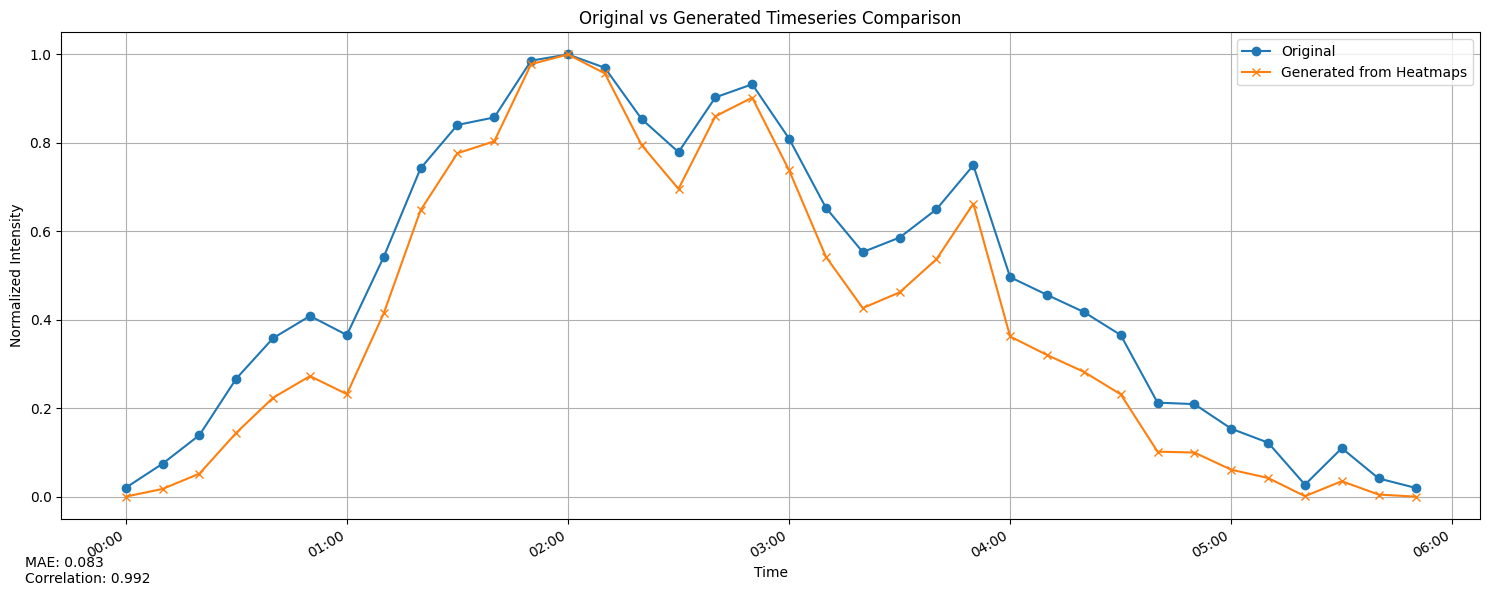

Correlation: 0.992
Mean Absolute Error: 0.083
Max Difference: 0.136


In [27]:
result = trend_generator.generate_trend_data(TEST_CONFIG[0], 1)

# Validate the generated heatmaps
validate_heatmap_generation(result)


Validating location 16:


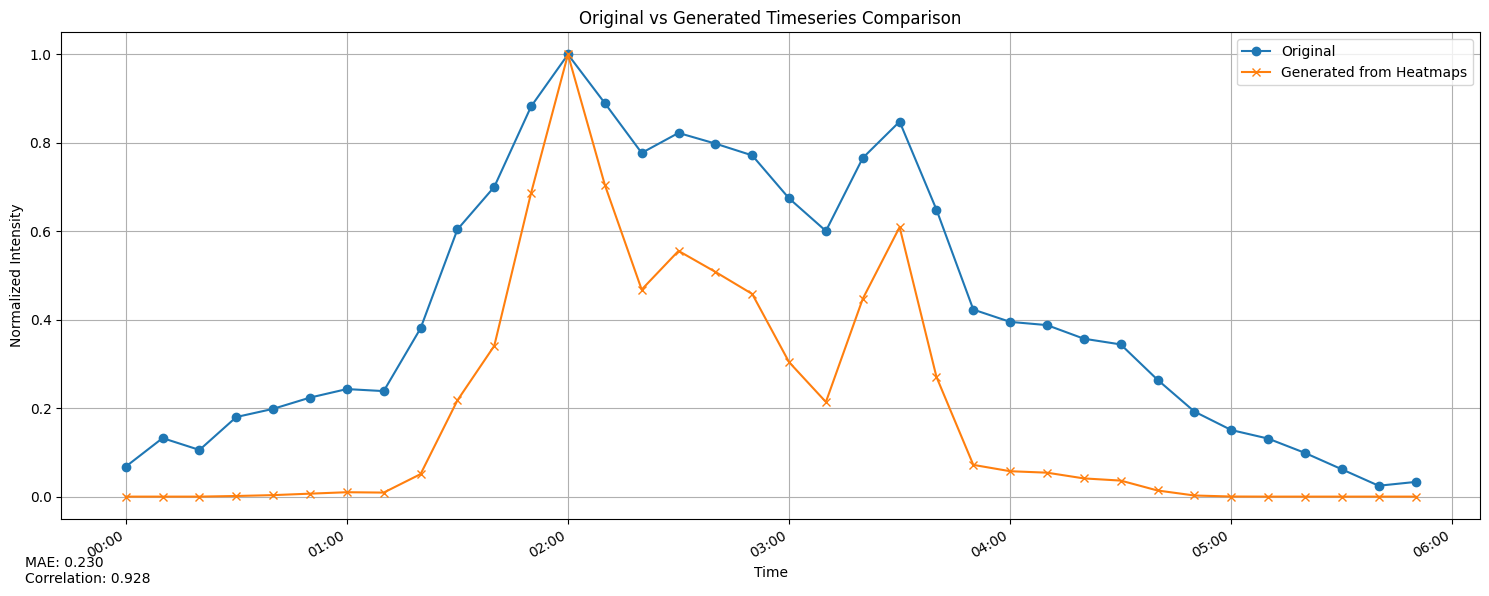

Correlation: 0.928
Mean Absolute Error: 0.230
Max Difference: 0.387


In [35]:
result = trend_generator.generate_trend_data(TEST_CONFIG[0], 1)

# Validate the generated heatmaps
validate_heatmap_generation(result)

In [9]:
TRENDS_CONFIG = [
    # Global Trends
    TrendConfig(
        name="ArtificialIntelligence",
        topic="TECH",
        locations=[SAN_FRANCISCO, NEW_YORK, BOSTON, SEATTLE],  # Tech hubs
        is_global=True,
        filename="ai-trend",
        timeseries_config=TimeSeriesConfig(
            hours_duration=6,
            window_minutes=10,
            num_peaks=8,
            start_time=datetime(2010, 1, 1).replace(tzinfo=pytz.UTC)),
        grid_size=1000,
        num_samples=1000,
        intensity_base=0.7,
        intensity_variance=0.2,
        hotspot_count=(3, 5),
        spread_range=(0.3, 0.6)
    ),
    TrendConfig(
        name="WorldCupFinal",
        topic="SPORT",
        locations=[MIAMI, LOS_ANGELES, NEW_YORK, CHICAGO, HOUSTON],  # Major metropolitan areas
        is_global=True,
        filename="worldcup-final",
        timeseries_config=TimeSeriesConfig(
            hours_duration=6,
            window_minutes=10,
            num_peaks=12,  # Many peaks for game events
            start_time=datetime(2010, 1, 1).replace(tzinfo=pytz.UTC)),
        grid_size=1000,
        num_samples=1200,
        intensity_base=0.9,
        intensity_variance=0.3,
        hotspot_count=(4, 6),
        spread_range=(0.4, 0.7)
    ),
    TrendConfig(
        name="StockMarketCrash",
        topic="FINANCES",
        locations=[NEW_YORK, CHICAGO, SAN_FRANCISCO, BOSTON],  # Financial centers
        is_global=True,
        filename="market-crash",
        timeseries_config=TimeSeriesConfig(
            hours_duration=6,
            window_minutes=10,
            num_peaks=6,
            start_time=datetime(2010, 1, 1).replace(tzinfo=pytz.UTC)),
        grid_size=1000,
        num_samples=900,
        intensity_base=0.8,
        intensity_variance=0.15,
        hotspot_count=(3, 4),
        spread_range=(0.2, 0.5)
    ),
    TrendConfig(
        name="MoviePremiere",
        topic="ENTERTAINMENT",
        locations=[LOS_ANGELES, NEW_YORK, MIAMI, CHICAGO],  # Entertainment hubs
        is_global=True,
        filename="movie-premiere",
        timeseries_config=TimeSeriesConfig(
            hours_duration=6,
            window_minutes=10,
            num_peaks=7,
            start_time=datetime(2010, 1, 1).replace(tzinfo=pytz.UTC)),
        grid_size=1000,
        num_samples=1100,
        intensity_base=0.75,
        intensity_variance=0.25,
        hotspot_count=(3, 5),
        spread_range=(0.3, 0.6)
    ),

    # Local Trends
    TrendConfig(
        name="SFTechConference",
        topic="TECH",
        locations=[SAN_FRANCISCO],
        is_global=False,
        filename="sf-conference",
        timeseries_config=TimeSeriesConfig(
            hours_duration=6,
            window_minutes=10,
            num_peaks=5,
            start_time=datetime(2010, 1, 1).replace(tzinfo=pytz.UTC)),
        grid_size=500,
        num_samples=800,
        intensity_base=0.8,
        intensity_variance=0.1,
        hotspot_count=(1, 2),
        spread_range=(0.1, 0.2)
    ),
    TrendConfig(
        name="LATrafficAlert",
        topic="POLITICS",  # City infrastructure issues
        locations=[LOS_ANGELES],
        is_global=False,
        filename="la-traffic",
        timeseries_config=TimeSeriesConfig(
            hours_duration=6,
            window_minutes=10,
            num_peaks=8,
            start_time=datetime(2010, 1, 1).replace(tzinfo=pytz.UTC)),
        grid_size=500,
        num_samples=750,
        intensity_base=0.7,
        intensity_variance=0.2,
        hotspot_count=(2, 3),
        spread_range=(0.2, 0.3)
    ),
    TrendConfig(
        name="ChicagoSportsRiot",
        topic="SPORT",
        locations=[CHICAGO],
        is_global=False,
        filename="chicago-sports",
        timeseries_config=TimeSeriesConfig(
            hours_duration=6,
            window_minutes=10,
            num_peaks=6,
            start_time=datetime(2010, 1, 1).replace(tzinfo=pytz.UTC)),
        grid_size=500,
        num_samples=900,
        intensity_base=0.9,
        intensity_variance=0.15,
        hotspot_count=(1, 2),
        spread_range=(0.15, 0.25)
    ),
    TrendConfig(
        name="MiamiBeachParty",
        topic="ENTERTAINMENT",
        locations=[MIAMI],
        is_global=False,
        filename="miami-party",
        timeseries_config=TimeSeriesConfig(
            hours_duration=6,
            window_minutes=10,
            num_peaks=9,
            start_time=datetime(2010, 1, 1).replace(tzinfo=pytz.UTC)),
        grid_size=500,
        num_samples=850,
        intensity_base=0.85,
        intensity_variance=0.2,
        hotspot_count=(1, 3),
        spread_range=(0.1, 0.2)
    )
]

result_v23 = trend_generator.generate_trends(TRENDS_CONFIG)

data_saver.save_trend_data_tiled("v23", *result_v23)

In [85]:
trends, trends_timeseries, _, trends_timeseries_heatmaps,  = result_v21

In [84]:
for trend_data in trend_timeseries_heatmaps.values():
    trend_count = 0
    for location_data in trend_data.values():
        for time_window_data in location_data.values():
            for point in time_window_data:
                trend_count += point['count']
    print(trend_count)

20565544
55052026
16433208
17253080
2952574
2788086
968480
665483


In [54]:
df_messages_raw = pd.read_json('../stream_generation/data/messages_raw.json')
messages_by_trend = df_messages_raw.groupby('trend_id')['text'].apply(list).to_dict()
df_messages_raw.head()

,trend_id,trend_name,topic,text
0,1,AI Model Breakthrough,TECH,"""Mind officially blown! Witnessed an AI model ..."
1,1,AI Model Breakthrough,TECH,"""This AI breakthrough is simply mind-blowing! ..."
2,1,AI Model Breakthrough,TECH,"""This AI breakthrough is mind-blowing! Human-l..."
3,1,AI Model Breakthrough,TECH,"""Interesting how #AI technology is advancing w..."
4,1,AI Model Breakthrough,TECH,"""This AI model breakthrough is taking the worl..."


In [98]:
from pyproj import Transformer
from datetime import datetime, timedelta
import numpy as np

# Create transformer once
MERCATOR_TO_WGS84 = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

def mercator_to_latlng(x: float, y: float):
    """Convert Web Mercator coordinates to lat/lon"""
    # Note: transform expects (x,y) and returns (lon,lat)
    lon, lat = MERCATOR_TO_WGS84.transform(x, y)
    return lat, lon  # Return as (lat,lon) for consistency with most APIs

def generate_message_points_for_trend(trend_id: str, 
                                location_id,
                                topic,
                                timeseries, 
                                heatmaps, 
                                window_minutes: int,
                                messages_by_trend,
                                total_messages: int = 10000):
    """Generate individual messages from trend's timeseries and heatmap data"""
    
    # Calculate message counts per window based on timeseries values
    total_value = sum(point['value'] for point in timeseries)
    messages_per_window = {
        point['timestamp']: int((point['value'] / total_value) * total_messages)
        for point in timeseries
    }
    
    messages = []
    
    # Generate messages for each window
    for timestamp, num_messages in messages_per_window.items():
        if num_messages == 0:
            continue
            
        # Get heatmap points for this timestamp
        heatmap_points = heatmaps[timestamp]
        
        # Calculate location probabilities from intensities
        total_intensity = sum(point['intensity'] for point in heatmap_points)
        if total_intensity == 0:
            continue
            
        location_weights = [point['intensity'] / total_intensity for point in heatmap_points]
        
        # Generate messages for this window
        for _ in range(num_messages):
            # Pick a heatmap point based on intensities
            point = np.random.choice(heatmap_points, p=location_weights)
            
            # Add some random spread around the point (in mercator coordinates)
            # Note: spread should be adjusted based on zoom level and desired spread distance
            spread = 1000  # 1km in mercator units (meters)
            x = point['coordinates'][0] + np.random.normal(0, spread)
            y = point['coordinates'][1] + np.random.normal(0, spread)
            
            # Convert to lat/lon
            lat, lon = mercator_to_latlng(x, y)
            
            # Random timestamp within the window
            window_start = datetime.fromisoformat(timestamp)
            window_end = window_start + timedelta(minutes=window_minutes)
            msg_timestamp = window_start + timedelta(
                seconds=np.random.uniform(0, window_minutes * 60)
            )
            
            messages.append({
                'trend_id': trend_id,
                'location_id': location_id,
                'topic': topic,
                'timestamp': msg_timestamp.replace(microsecond=0).isoformat(),
                'lon': lon,
                'lat': lat,
                'text': random.choice(messages_by_trend[trend_id]),
            })
    
    return sorted(messages, key=lambda x: x['timestamp'])

In [10]:
trends, trends_timeseries, _, trends_timeseries_heatmaps,  = result_v23

In [99]:
message_points = []

for trend_id, trend_config in enumerate(TRENDS_CONFIG, 1):
    for location_id, trend_location_heatmaps in trends_timeseries_heatmaps[trend_id].items():
        
        message_points.extend(generate_message_points_for_trend(
            trend_id, 
            location_id,
            trend_config.topic,
            trends_timeseries[trend_id], 
            trend_location_heatmaps,
            trend_config.timeseries_config.window_minutes,
            messages_by_trend,
            total_messages=500))
           
print(len(message_points))

9690


In [100]:
df = pd.DataFrame(message_points)
df.head()

,trend_id,location_id,topic,timestamp,lon,lat,text
0,1,3,TECH,2010-01-01T02:00:01+00:00,-122.248328,37.770575,"""Interesting how #AI is evolving. Revolutionar..."
1,1,3,TECH,2010-01-01T02:00:35+00:00,-122.235535,37.855495,"""This AI breakthrough is mindblowing! The mode..."
2,1,3,TECH,2010-01-01T02:02:52+00:00,-122.018845,37.568025,"""This AI breakthrough is mind-blowing! Human-l..."
3,1,3,TECH,2010-01-01T02:08:07+00:00,-121.983339,37.566845,"""This AI breakthrough is blowing my mind! Huma..."
4,1,3,TECH,2010-01-01T02:09:04+00:00,-121.956451,37.583593,"""Mind blown! Latest AI model achieves human-li..."


In [94]:
df.groupby(['trend_id', 'location_id'])['text'].count().reset_index().sort_values(['trend_id', 'location_id'])

,trend_id,location_id,text
0,1,3,468
1,1,6,468
2,1,14,468
3,1,16,468
4,2,2,456
5,2,5,456
6,2,8,456
7,2,16,456
8,2,19,456
9,3,3,460


In [101]:
df.rename(
    columns={'location_id': 'd_location_id', 'trend_id': 'd_trend_id'}
).to_json(
    '../trend_detection/data/trend_messages_v23.json', orient='records'
)

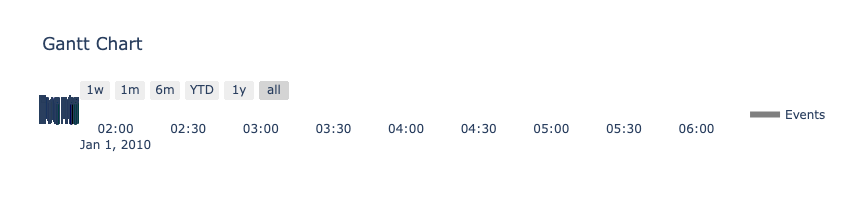

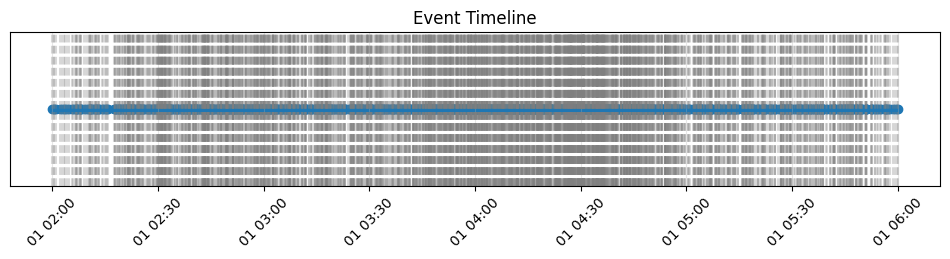

In [103]:
import plotly.figure_factory as ff
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming you have a list of timestamps
timestamps = df[df['trend_id'] == 1]['timestamp']

# 1. Using Plotly (Interactive)
def plot_timeline_plotly(timestamps):
    # Convert to datetime if needed
    dates = [pd.to_datetime(ts) for ts in timestamps]
    
    # Create data for plotly
    df = [dict(Task="Events", Start=d, Finish=d, Resource='Event') for d in dates]
    
    # Create timeline
    fig = ff.create_gantt(df, show_colorbar=True, showgrid_x=True, showgrid_y=True)
    fig.update_layout(height=200)  # Adjust height as needed
    
    return fig

# 2. Using Matplotlib (Simple static version)
def plot_timeline_matplotlib(timestamps):
    # Convert to datetime if needed
    dates = [pd.to_datetime(ts) for ts in timestamps]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 2))
    
    # Plot events
    ax.scatter(dates, [1]*len(dates), marker='o')
    
    # Add vertical lines
    for date in dates:
        ax.axvline(x=date, color='gray', linestyle='--', alpha=0.3)
    
    # Format
    ax.set_yticks([])  # Hide y-axis
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.title('Event Timeline')
    
    return fig

# Example usage:
# For Plotly
fig = plot_timeline_plotly(timestamps)
fig.show()

# For Matplotlib
fig = plot_timeline_matplotlib(timestamps)
plt.show()

In [116]:
timestamps = list(map(datetime.fromisoformat, df[df['trend_id'] == 1]['timestamp']))

diff_seconds = []
for t1, t2 in zip(timestamps, timestamps[1:]):
    diff_seconds.append((t2 - t1).seconds)

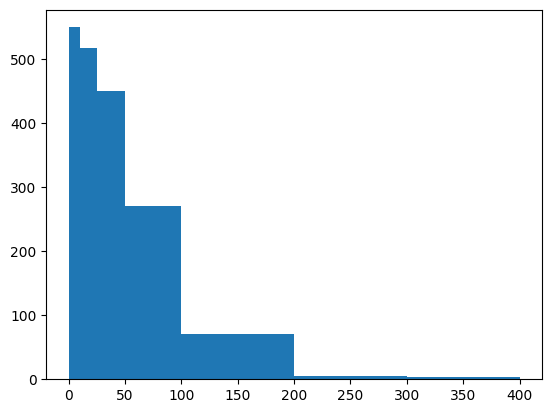

In [131]:
plt.hist(diff_seconds, bins=[0, 10, 25, 50, 100, 200, 300, 400]);

In [143]:
points = []

for trend_id, trend_config in enumerate(TRENDS_CONFIG, 1):
    for location_id, trend_location_heatmaps in trends_timeseries_heatmaps[trend_id].items():
        for ts, ts_points in trend_location_heatmaps.items():
            pass
            #print(trend_id, location_id, ts, len(ts_points))

In [144]:
# 2 19 2010-01-01T02:10:00+00:00
points = trends_timeseries_heatmaps[2][19]['2010-01-01T02:10:00+00:00']
len(points)

2987

In [146]:
result = data_saver.create_tiles(points, [3, 6, 9, 12])

In [153]:
zoom_tiles = defaultdict(lambda: defaultdict(int))
for (zoom, x, y), val in result.items():
    zoom_tiles[zoom][(x, y)] += len(val.points)

In [154]:
zoom_tiles

defaultdict(<function __main__.<lambda>()>,
            {3: defaultdict(int, {(1, 3): 5}),
             6: defaultdict(int, {(15, 26): 42, (14, 26): 4}),
             9: defaultdict(int, {(120, 211): 334, (119, 211): 39}),
             12: defaultdict(int,
                         {(956, 1688): 5,
                          (957, 1688): 5,
                          (957, 1689): 18,
                          (957, 1692): 2,
                          (957, 1691): 9,
                          (957, 1690): 5,
                          (958, 1692): 49,
                          (958, 1689): 19,
                          (958, 1693): 46,
                          (958, 1694): 1,
                          (958, 1690): 8,
                          (959, 1693): 86,
                          (959, 1692): 82,
                          (959, 1690): 26,
                          (959, 1689): 8,
                          (959, 1691): 17,
                          (959, 1694): 10,
                    